# Filter TF network edges by expected counts
### Describes a regimen to filter human TF interactions in the edge list produced by `build_network.ipynb`

In [32]:
import csv
from collections import defaultdict
import numpy as np
import json
import pandas as pd
import random
import statistics 
import scipy.stats as stats
import tqdm
from itertools import islice
from matplotlib import pyplot as plt

In [ ]:
transpose_dir = './build_network_out'
edgedir = './filtered_edges'
network_dir = './network_files'

## Shuffle signature sets between source TFs

Upload signature sets which are enriched by each TF. Produces a dictionary formatted as `tf:[signature1 ... signatureN]`

In [ ]:
# read in tf_transpose.gmt and upload it into an edge list
# upload humanedge.csv to a dictionary

signature_file = f"{transpose_dir}/tf_transpose.gmt"
signature_sets = defaultdict(set)


with open(signature_file, "r") as file:
    for line in tqdm.tqdm(file):
        tf, *signature = line.strip().split()
        signature_sets[tf] = set(signature)
    

# now shuffle sets between terms
def shuffle_signatures(signature_sets):
    tfs = list(signature_sets.keys())
    sigs = list(signature_sets.values())

    random.shuffle(sigs)

    shuffled_sigsets = dict(zip(tfs, sigs))
    
    return shuffled_sigsets

Upload RummaGEO gene sets to produce counts

In [ ]:
def read_gmt2(path):
  gmt = {}
  print("Reading {}".format(path))
  with open(path, "r") as file:
    for line in tqdm.tqdm(file):
      # 'id' refers to up or down tag
      signature, id, *tf = line.strip().split()
      gmt[" ".join([signature, id])] = set(tf)

  return gmt

geo_gmt = read_gmt2("raw_data/human-geo-auto.gmt")

## Recalculate counts

Produce an edge list using the randomly shuffled signature sets. Repeat several times and store counts. 

Produces a dictionary formatted 
`
{ source: { 
    target: { 
            '+': np.array(up_counts_all_trials)
            '-': np.array(dn_counts_all_trials)
        }
    }
}
`

In [ ]:
N_TRIALS = 50

# Create dict
all_high_tfs = list(signature_sets.keys())

expected_counts = {source : {target : {
    "+": np.zeros(N_TRIALS),
    "-": np.zeros(N_TRIALS),
  } for target in all_high_tfs} for source in all_high_tfs}

for i in tqdm.tqdm(range(N_TRIALS)):
  shuffled_sets = shuffle_signatures(signature_sets)

  # Calculate counts
  for source in all_high_tfs:
    for signature in shuffled_sets[source]:

      spl = signature.rsplit("-", 1)
      dir = "+" if spl[1] == "up" else "-" # "dn"
      joined_sig = " ".join(spl)

      # if the gene set name is in the keys for the rummaGEO GMT
      if joined_sig in geo_gmt.keys():
        
        # for each TF in the list of all TFs
        for target in all_high_tfs:
          
          if target in geo_gmt[joined_sig]: # TF is in list of DEGs
            expected_counts[source][target][dir][i] += 1
    
      else:
        raise Exception("Signature {} not found".format(joined_sig))


## Calculate significance of observed counts

Upload observed counts from initially filtered edge list into a dictionary 

In [ ]:
# upload humanedge.csv to a dictionary
obs_file = f"{edgedir}/edge_list.csv"
observed_counts = {source : {target : {
    "+": 0,
    "-": 0,
  } for target in all_high_tfs} for source in all_high_tfs}

with open(obs_file, 'r') as file:
    reader = csv.reader(file)
    next(reader) # skip header
    for source,target,direction,count in reader:
        if direction == "+" or direction == "-":
            observed_counts[source][target][direction] = int(count)

In [ ]:
# make a similar array to store stats 
hindex = pd.MultiIndex.from_product([all_high_tfs, all_high_tfs, ['+', '-']],
  names = ["source", "target", "direction"])
edge_statistics = pd.DataFrame(index = hindex, columns = ["observed", "expected", "expected stdev", "z-score", "p-value"])


for source, targets in tqdm.tqdm(expected_counts.items()):
  for target, data in targets.items():
    for dir, counts in data.items():
      # find expected and observed counts 
      obsv_counts = observed_counts[source][target][dir]

      # calculate statistics 
      mean = statistics.mean(counts)
      stdev = statistics.stdev(counts)
      if stdev != 0:
        z_score = (obsv_counts - mean) / (stdev)
        p_value = 1 - stats.norm.cdf(z_score)
      else:
        z_score = float('inf')
        p_value = 2


      # store in dataframe 
      edge_statistics.loc[(source, target, dir)] = [obsv_counts, mean, stdev, z_score, p_value]



In [ ]:
z_sorted = edge_statistics.sort_values(by='z-score')
p_sorted = edge_statistics.sort_values(by='p-value')

Save collected statistics to a file

In [ ]:
z_sorted.to_csv(f"{edgedir}/z_sorted_edge_statistics", sep='\t')
p_sorted.to_csv(f"{edgedir}/p_sorted_edge_statistics", sep='\t')

Remove insignificant edges. For pairs that have significant edges in both directions, keep only the edge with the most significance.

In [27]:
Z_MIN = 13.0

# work from a copy since we're removing entries directly
significant_edges = edge_statistics.loc[((edge_statistics['z-score'] != float('Inf')) & (edge_statistics['z-score'] > Z_MIN))]
final_edge_list = significant_edges.copy()
edges_to_drop = []

# search source-target pairs and retain only the edge with the highest significance 
for (source, target), group in final_edge_list.groupby(level=['source', 'target']):

    directions = group.index.get_level_values('direction')
    up_exists = '+' in directions
    dn_exists = '-' in directions

    if up_exists and dn_exists:
        # Filter to get '+' and '-' entries
        up_data = group.loc[(slice(None), slice(None), '+'), :]
        dn_data = group.loc[(slice(None), slice(None), '-'), :]   

        # remove lower z-score
        if up_data['z-score'].values[0] < dn_data['z-score'].values[0]:
          edges_to_drop.append((source, target, '+')) 
        else:
          edges_to_drop.append((source, target, '-'))

final_edge_list.drop(index=edges_to_drop, inplace=True)

Save results

In [28]:
#final_edge_list.to_csv(f"{edgedir}/filtered_edges.csv")
# one_significant_edge.to_json(f"{edgedir}/filtered_edges.json")

## Format data for UI ingestion
### Format edges: [source, direction, target]

In [ ]:
new_index = ['source','direction','target']

final_edge_list.reindex(index=new_index)

index = final_edge_list.index.to_frame()

print(index)

final_edge_list.to_csv(f"{network_dir}/Transcription_Factor.Direction.Transcription_Factor.edges.csv", index = False)

### Format nodes: [tf_name]

In [ ]:
nodes = set()

# collect all source and target nodes, without duplicates 
for (source, target), group in final_edge_list.groupby(level=['source', 'target']):
    nodes.add(source)
    nodes.add(target)


# convert to df for easy csv formatting
node_df = pd.DataFrame(list(nodes), columns=['Index'])
node_df.to_csv(f'{network_dir}/Transcription_factor.csv', index = False)

## Optional - plot histograms

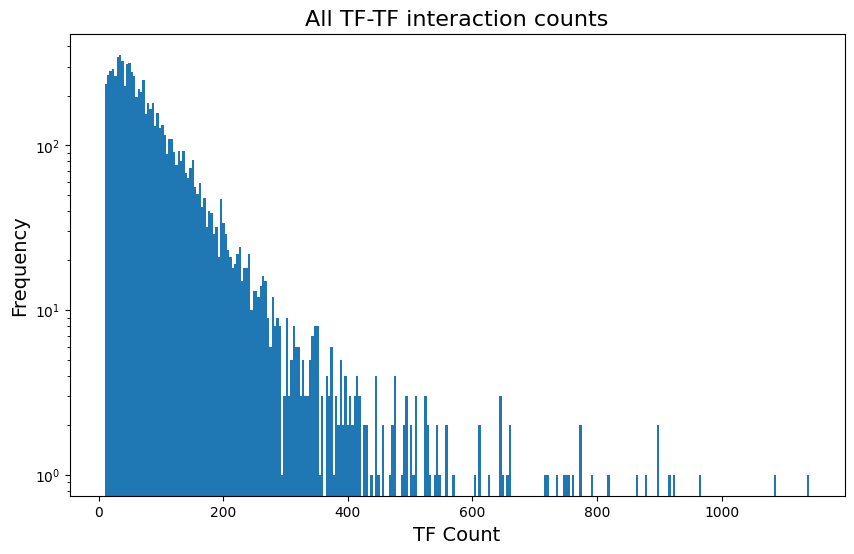

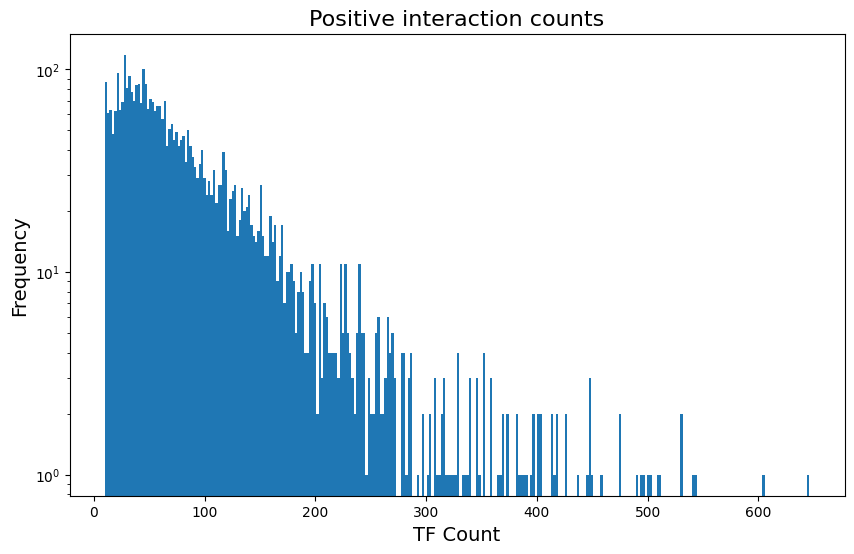

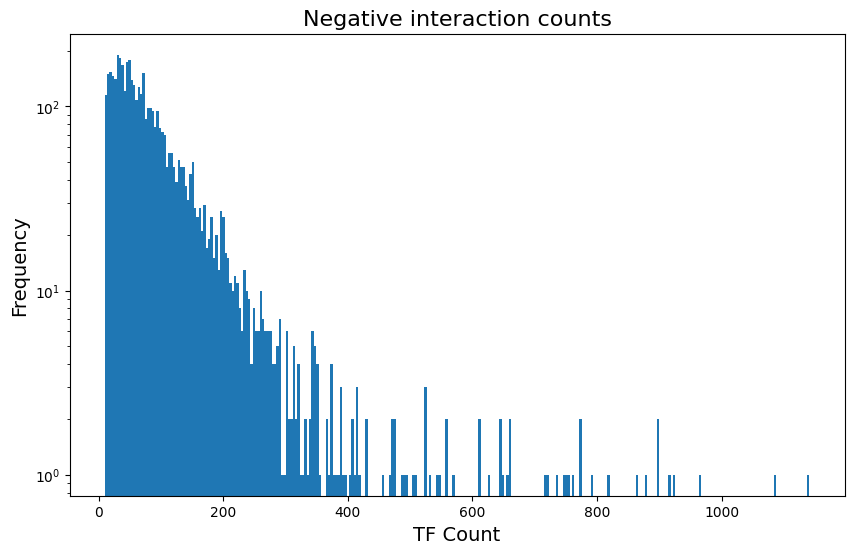

In [34]:
# Plot log-scaled histogram of counts

def tf_histogram(name, counts, num_bins=300, fig_size=(10,6)):
    plt.figure(figsize=fig_size)
    plt.hist(counts, bins = num_bins, edgecolor ='none')
    plt.yscale('log')
    plt.xlabel('Interaction count', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    if name == "all":
        plt.title('All TF-TF interaction counts', fontsize=16)
    elif name == "pos":
        plt.title('Positive interaction counts', fontsize=16)
    elif name == "neg": 
        plt.title('Negative interaction counts', fontsize=16)


# get count values
all_counts = one_significant_edge['observed']
# Filter the DataFrame for rows where the direction is "+"
positive_counts = one_significant_edge.loc[(slice(None), slice(None), "+"), :]['observed']
# Filter the DataFrame for rows where the direction is "+"
negative_counts = one_significant_edge.loc[(slice(None), slice(None), "-"), :]['observed']

tf_histogram("all", all_counts)
plt.savefig(f"{edgedir}/img/all_histo_filtered.png")
plt.show()

tf_histogram("pos", positive_counts)
plt.savefig(f"{edgedir}/img/pos_histo_filtered.png")
plt.show()

tf_histogram("neg", negative_counts)
plt.savefig(f"{edgedir}/img/neg_histo_filtered.png")
plt.show()

Format list for ingestion to the KG UI and save 

In [ ]:
out_edges = one_significant_edge.loc[['observed','z-score']]

out_edges.to_csv(f"network_files/edges.csv")